<a href="https://colab.research.google.com/github/MaayanHagbi/CAS_ADS_Final_Project/blob/main/Fraud_Detection_ML_(CAS_ADS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount Drive & Authenticate Google Big Query Access

In [84]:
from google.colab import drive
from google.colab import auth
drive.mount('/content/drive')
auth.authenticate_user()
print('Authenticated')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Authenticated


#Load Packages

In [85]:
#Google Big Query related packages
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
!pip install geoip2
import geoip2.database
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import RobustScaler

#Clone Repository
!git clone https://github.com/MaayanHagbi/CAS_ADS_Final_Project

fatal: destination path 'CAS_ADS_Final_Project' already exists and is not an empty directory.


# Connect to Big Query and Get Data

In [86]:
project_id = 'total-biplane-387513'
bigquery_client = bigquery.Client(project = project_id)

Query = """
    Select distinct * from (
    Select * from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where
    Clientinfo_id in (Select distinct Clientinfo_id from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset`
    where Chargebackreason_code in ('10','10.4','4837'))
    union all
    Select * from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Clientinfo_id in (
    Select distinct Clientinfo_id from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset`
    where Clientinfo_id not in (Select Clientinfo_id from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset`
    where Chargebackreason_id is null and Clientinfo_id not in ((Select distinct Clientinfo_id from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset`
    where Chargebackreason_code in ('10','10.4','4837')))) limit 5000)
    ); """
Query_Results = bigquery_client.query(Query)
Data_Adf = Query_Results.to_dataframe()

#Conversion and Creation of Variables

In [87]:
def convert_float(columns):
  for col in columns:
    Data_Adf[col] = pd.to_numeric(Data_Adf[col],errors='coerce')

def convert_string(columns):
  for col in columns:
    Data_Adf[col] = Data_Adf[col].astype(str)

columns_to_string = ['id']
columns_to_float = ['amount_gbp']

convert_float(columns_to_float)
convert_string(columns_to_string)

#Add Is_fraud Column
Data_Adf['Is_fraud'] = Data_Adf['Chargebackreason_id'].notnull()

#Data Analysis

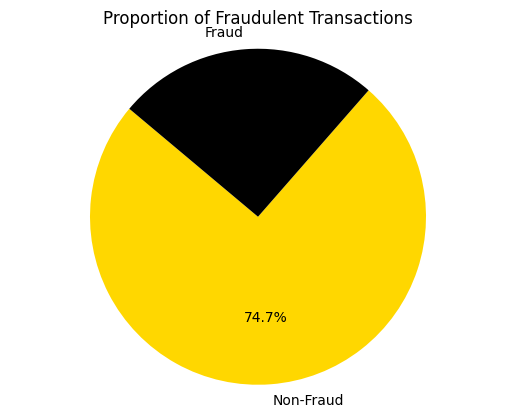

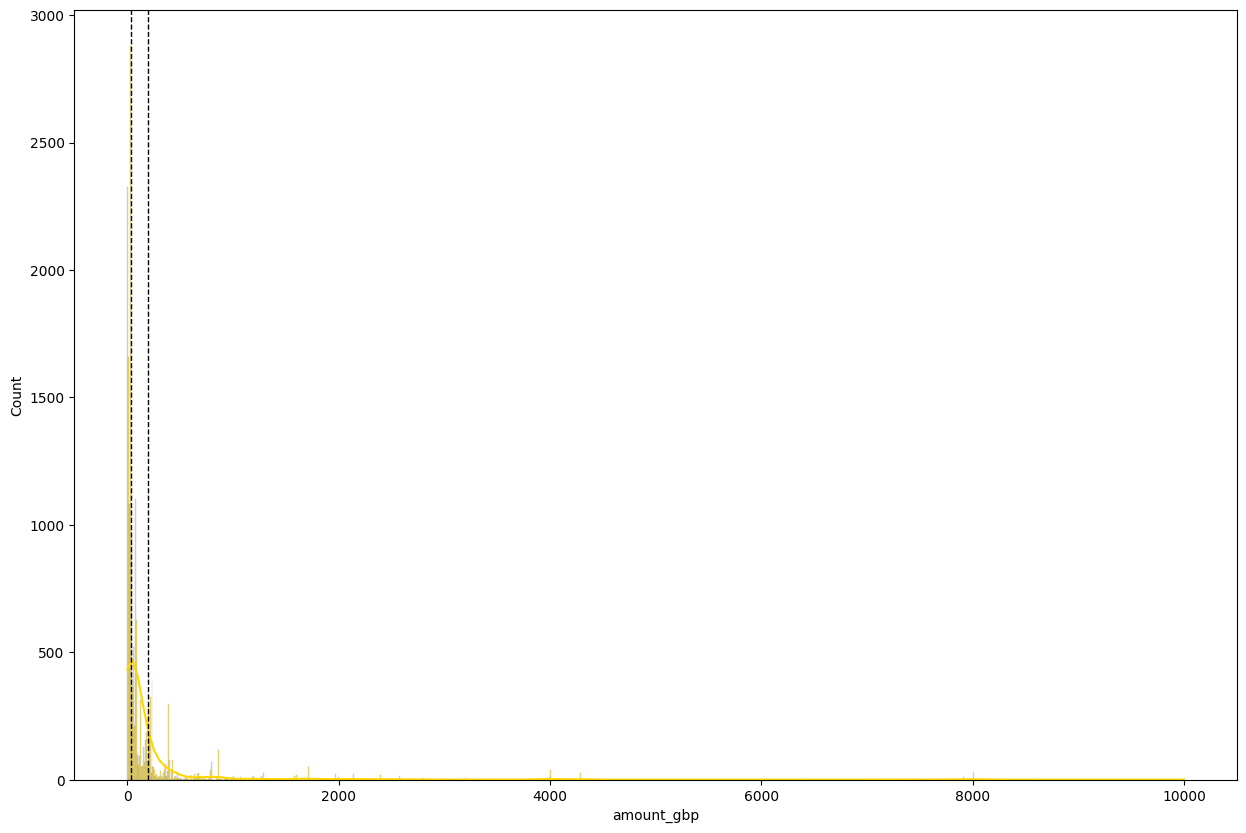

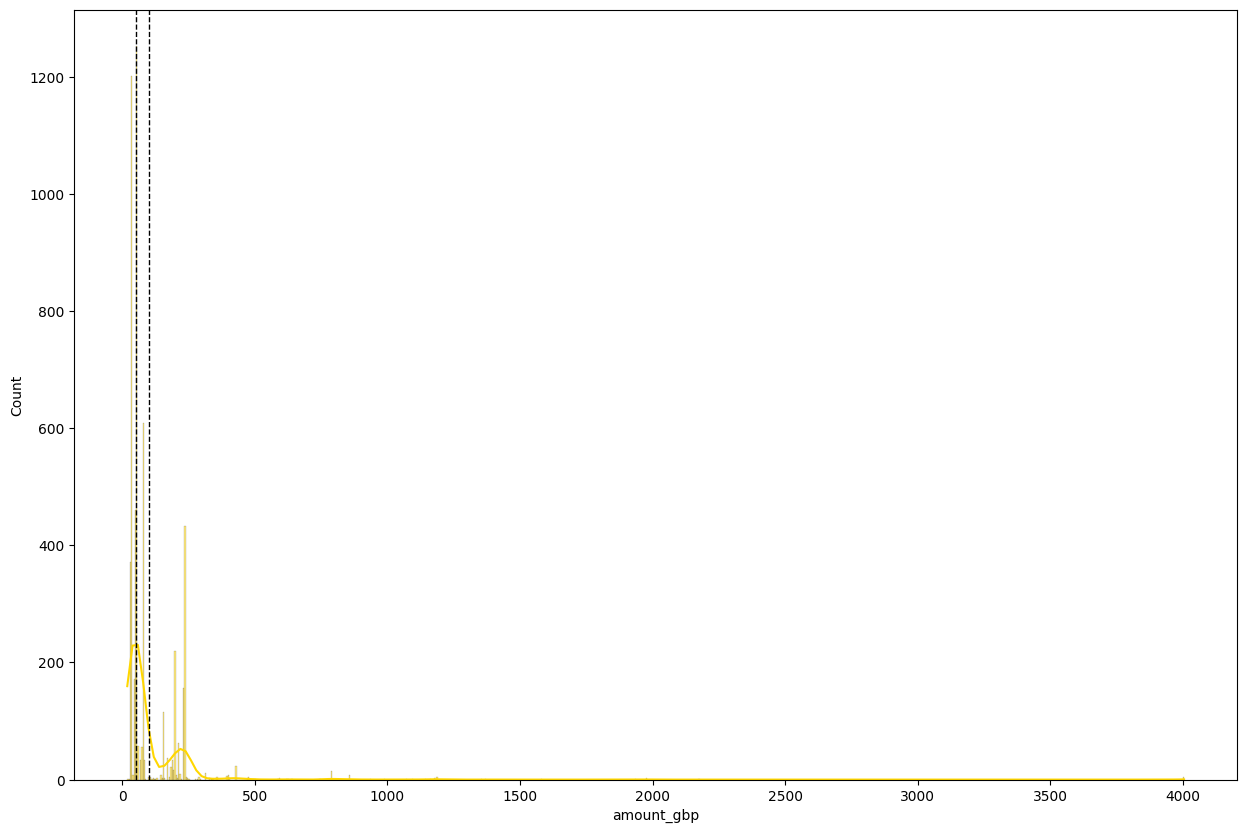

In [88]:
#Look into share of fradulent trx vs non-fraudulent
Data_Adf["Is_fraud"].value_counts().plot.pie(labels=['Non-Fraud','Fraud'],colors=['gold','black'], autopct='%1.1f%%',startangle=140,textprops={'color':"black"})
plt.title('Proportion of Fraudulent Transactions')
plt.ylabel('')
plt.axis('equal')
plt.show()

#Check Amount distribution of Fraudulent Vs non Fraudulent Trx
fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==True]
non_fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==False]

#Trx_amount_gbp
plt.figure(figsize=(15,10))
sns.histplot(non_fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black')
mean_value = np.mean(non_fraudulent_df["amount_gbp"])
median_value = np.median(non_fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1)
plt.axvline(median_value, color='black', linestyle='dashed', linewidth=1)
plt.show()


plt.figure(figsize=(15,10))
sns.histplot(fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black')
mean_value = np.mean(fraudulent_df["amount_gbp"])
median_value = np.median(fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1)
plt.axvline(median_value, color='black', linestyle='dashed', linewidth=1)
plt.show()

In [89]:
cust_profiles = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].agg(['mean','median'])
len(cust_profiles)

9944

#Generate Customer Profiles (Cust_Profiles)

In [90]:
#Calcualte Customer Profile Statistics
cust_profiles = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].agg(['mean','median']).reset_index()
cust_profiles.columns = ['client_id','cust_profiles_mean_gbp_amount','cust_profiles_median_gbp_amount']
cust_profiles_std = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].std(ddof=0).reset_index()
cust_profiles_std.columns = ['client_id','cust_profiles_std_gbp_amount']


#Calcualte Average Number of Trx
Data_Adf['timestamp'] = pd.to_datetime(Data_Adf['timestamp'],errors='coerce')
trx_per_day_per_customer = Data_Adf.groupby(['Clientinfo_id', Data_Adf['timestamp'].dt.date]).size().reset_index(name='num_transactions')
mean_nb_trx_per_day = trx_per_day_per_customer.groupby('Clientinfo_id')['num_transactions'].mean().reset_index()
mean_nb_trx_per_day.columns = ['client_id','cust_profiles_mean_nb_trx_per_day']

#Merge Datasets to one
Cust_Profiles = pd.merge(cust_profiles,cust_profiles_std,on='client_id')
Cust_Profiles = pd.merge(cust_profiles,mean_nb_trx_per_day,on='client_id')

#Cust_Profiles_Data
Cust_Profiles

,client_id,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,1058555,53.65,53.65,1.0
1,1058557,53.65,53.65,1.0
2,1058558,157.75,157.75,1.0
3,1058568,157.75,157.75,1.0
4,1058569,157.75,157.75,1.0
...,...,...,...,...
9939,4639634,44.62,44.62,1.0
9940,4640530,80.07,80.07,1.0
9941,4641102,240.20,240.20,1.0
9942,4641824,31.23,31.23,1.0


# Get Customer Country from IP Address / Card Info (Cust_Country_Profile)

In [91]:
def get_country(ip):
    mmdb_file_path = '/content/drive/MyDrive/CAS_Final_Project/GeoLite2-City.mmdb' #Maayan's source
    # mmdb_file_path = '/content/drive/MyDrive/Colab_Notebooks/CAS_Final_Project/GeoLite2-City.mmdb' #Viki's source

    if pd.notna(ip) and ip != 'nan':
        try:
            with geoip2.database.Reader(mmdb_file_path) as reader:
                response = reader.city(ip)

                country_name = response.country.name
                country_iso_code = response.country.iso_code
                return country_name, country_iso_code
        except Exception as e:
            return 0, 0
    else:
        return 0, 0

df_Country_lan_lat = pd.read_csv("/content/drive/MyDrive/CAS_Final_Project/Country_lan_lat.csv",sep=';') #Maayan's source
# df_Country_lan_lat = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/CAS_Final_Project/Country_lan_lat.csv",sep=';') #Viki's source

In [92]:
#Get Customer Device IP Coordinates (Country)
Cust_Country_Profile_Ip = Data_Adf[['id','Clientinfo_id','Deviceinfo_ip']].copy()
Cust_Country_Profile_Ip['Deviceinfo_ip'] = Cust_Country_Profile_Ip['Deviceinfo_ip'].astype(str)
Cust_Country_Profile_Ip[['country_name','country']] = Cust_Country_Profile_Ip['Deviceinfo_ip'].apply(lambda x:  pd.Series(get_country(x)))

merge_df = pd.merge(Cust_Country_Profile_Ip,df_Country_lan_lat,on='country',how='left')

columns_to_keep = ['id','Clientinfo_id','latitude','longitude']
Cust_Country_Profile_Ip = merge_df[columns_to_keep]

old_colums_names = ['id','Clientinfo_id','latitude','longitude']
new_columns_names = ['id','client_id','latitude_ip','longitude_ip']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Cust_Country_Profile_Ip = Cust_Country_Profile_Ip.rename(columns=new_columns_dic)
Cust_Country_Profile_Ip

,id,client_id,latitude_ip,longitude_ip
0,2363618,1270430,NaN,NaN
1,2335907,1258791,NaN,NaN
2,2347056,1263341,NaN,NaN
3,2126544,1166855,NaN,NaN
4,2129919,1172490,NaN,NaN
...,...,...,...,...
21885,9761766,3369798,52.132633,5.291266
21886,8163913,3008016,61.924110,25.748151
21887,10765450,4321565,52.132633,5.291266
21888,8666469,2259597,61.924110,25.748151


In [93]:
#Get Customer Card Issuer Bank Coordinates (Country)
Card_Info_Country_Profile = Data_Adf[['id','Clientinfo_id','Countries_iso2']].copy()
Card_Info_Country_Profile = Card_Info_Country_Profile.fillna(0)
old_colums_names = ['Countries_iso2']
new_columns_names = ['country']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Card_Info_Country_Profile = Card_Info_Country_Profile.rename(columns=new_columns_dic)
merge_df = pd.merge(Card_Info_Country_Profile,df_Country_lan_lat,on='country',how='left')
columns_to_keep = ['id','Clientinfo_id','latitude','longitude']
Card_Info_Country_Profile = merge_df[columns_to_keep]
old_colums_names = ['id','Clientinfo_id','latitude','longitude']
new_columns_names = ['id','client_id','latitude_card','longitude_card']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Card_Info_Country_Profile = Card_Info_Country_Profile.rename(columns=new_columns_dic)
Card_Info_Country_Profile

,id,client_id,latitude_card,longitude_card
0,2363618,1270430,NaN,NaN
1,2335907,1258791,NaN,NaN
2,2347056,1263341,NaN,NaN
3,2126544,1166855,NaN,NaN
4,2129919,1172490,NaN,NaN
...,...,...,...,...
21885,9761766,3369798,52.132633,5.291266
21886,8163913,3008016,61.924110,25.748151
21887,10765450,4321565,52.132633,5.291266
21888,8666469,2259597,61.924110,25.748151


In [94]:
duplicate_rows = Card_Info_Country_Profile[Card_Info_Country_Profile.duplicated(subset=['id'])]
duplicate_rows

,id,client_id,latitude_card,longitude_card


In [95]:
#Customer Country Coordinates (Final)
merge_df = pd.merge(Cust_Country_Profile_Ip,Card_Info_Country_Profile,how = 'left', on='id')
print(len(merge_df))
merge_df.columns
columns_to_keep = ['id', 'client_id_x', 'latitude_ip', 'longitude_ip','latitude_card', 'longitude_card']
Cust_Country_Profile = merge_df[columns_to_keep]
Cust_Country_Profile.columns

old_colums_names = ['id', 'client_id_x', 'latitude_ip', 'longitude_ip', 'latitude_card','longitude_card']
new_columns_names = ['id', 'client_id', 'latitude_ip', 'longitude_ip', 'latitude_card','longitude_card']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Cust_Country_Profile = Cust_Country_Profile.rename(columns=new_columns_dic)

Cust_Country_Profile.set_index('id',inplace=True)
Cust_Country_Profile.index = Cust_Country_Profile.index.astype(int)
Cust_Country_Profile

21890


,client_id,latitude_ip,longitude_ip,latitude_card,longitude_card
id,,,,,
2363618,1270430,NaN,NaN,NaN,NaN
2335907,1258791,NaN,NaN,NaN,NaN
2347056,1263341,NaN,NaN,NaN,NaN
2126544,1166855,NaN,NaN,NaN,NaN
2129919,1172490,NaN,NaN,NaN,NaN
...,...,...,...,...,...
9761766,3369798,52.132633,5.291266,52.132633,5.291266
8163913,3008016,61.924110,25.748151,61.924110,25.748151
10765450,4321565,52.132633,5.291266,52.132633,5.291266


# Get Transaction Profile (Trx_Profile)

In [96]:
def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

def is_weekend(date):
    return date.weekday() >= 5

def get_client_spending_behaviour_features(customer_trx, window_size_in_days = [1,7,30]):

  customer_trx = customer_trx.sort_values('timestamp')
  customer_trx.index = customer_trx.timestamp

  for window_size in window_size_in_days:
    sum_amount_trx_window = customer_trx['amount_gbp'].rolling(str(window_size)+'d').sum()
    nb_trx_window = customer_trx['amount_gbp'].rolling(str(window_size) + 'd').count()

    avg_amount_trx_window = sum_amount_trx_window/nb_trx_window

    customer_trx['client_nb_trx_' + str(window_size) + 'day_window'] = list(nb_trx_window)
    customer_trx['client_avg_amount_'+str(window_size) + 'day_window'] = list(avg_amount_trx_window)

  customer_trx.index = customer_trx.id

  return customer_trx

#Trx Profiles table
Trx_Profile = Data_Adf[['id','timestamp','Clientinfo_id','amount_gbp']].copy()
Trx_Profile.loc[:,'time'] = Trx_Profile['timestamp'].dt.time
Trx_Profile.loc[:,'trx_time_seconds'] = Trx_Profile['time'].apply(lambda x: time_to_seconds(x))
Trx_Profile.loc[:,'date'] = Trx_Profile['timestamp'].dt.date
Trx_Profile.loc[:,'is_WKE?'] = Trx_Profile['date'].apply(lambda x: is_weekend(x)).astype(int)

target_time = pd.to_datetime('22:00:00').time()
Trx_Profile.loc[:,'is_night?'] = (Trx_Profile['time'] > target_time).astype(int)


columns_to_drop = ['time','date']
Trx_Profile = Trx_Profile.drop(columns=columns_to_drop)
old_colums_names = Trx_Profile.columns
new_columns_names = ['id','timestamp','client_id','trx_amount_gbp','trx_time_seconds','trx_is_weekend']
new_columns_dic = {k: v for k, v in zip(old_colums_names,new_columns_names)}

Trx_Profile = Trx_Profile.rename(columns=new_columns_dic)

Trx_Profile.set_index('id',inplace=True)
Trx_Profile.index = Trx_Profile.index.astype(int)
Trx_Profile

,timestamp,client_id,trx_amount_gbp,trx_time_seconds,trx_is_weekend,is_night?
id,,,,,,
2363618,2021-02-25 19:21:34+00:00,1270430,53.65,69694,0,0
2335907,2021-02-20 17:59:54+00:00,1258791,37.64,64794,1,0
2347056,2021-02-22 22:46:24+00:00,1263341,37.64,81984,0,1
2126544,2021-01-10 09:34:55+00:00,1166855,53.65,34495,1,0
2129919,2021-01-10 19:00:15+00:00,1172490,237.83,68415,1,0
...,...,...,...,...,...,...
9761766,2023-10-16 10:50:59+00:00,3369798,26.78,39059,0,0
8163913,2023-05-02 09:37:09+00:00,3008016,130.07,34629,0,0
10765450,2024-01-31 20:50:13+00:00,4321565,48.16,75013,0,0


# Get Customer Behavoiur Profile (Trx_Profile_Rolling)

In [97]:
#Customer Behaviour Profile
Trx_Profile_Rolling = Data_Adf[['id','timestamp','Clientinfo_id','amount_gbp']].copy()

Trx_Profile_Rolling['timestamp'] = Trx_Profile_Rolling['timestamp'].dt.tz_localize(None)
Trx_Profile_Rolling['timestamp'] = Trx_Profile_Rolling['timestamp'].astype('datetime64[ns]')

Trx_Profile_Rolling = Trx_Profile_Rolling.sort_values(['timestamp','Clientinfo_id'], ascending=[True,True],ignore_index=True)

%time Trx_Profile_Rolling = Trx_Profile_Rolling.groupby('Clientinfo_id').apply(lambda x: get_client_spending_behaviour_features(x))

Trx_Profile_Rolling.set_index('id',inplace=True)
Trx_Profile_Rolling.index = Trx_Profile_Rolling.index.astype(int)
Trx_Profile_Rolling

CPU times: user 43.8 s, sys: 845 ms, total: 44.6 s
Wall time: 44.1 s


,timestamp,Clientinfo_id,amount_gbp,client_nb_trx_1day_window,client_avg_amount_1day_window,client_nb_trx_7day_window,client_avg_amount_7day_window,client_nb_trx_30day_window,client_avg_amount_30day_window
id,,,,,,,,,
1983485,2021-01-01 00:01:07,1058555,53.65,1.0,53.65,1.0,53.65,1.0,53.65
1983490,2021-01-01 00:08:21,1058557,53.65,1.0,53.65,1.0,53.65,1.0,53.65
2006281,2021-01-05 10:54:33,1058558,157.75,1.0,157.75,1.0,157.75,1.0,157.75
1983522,2021-01-01 00:37:17,1058568,157.75,1.0,157.75,1.0,157.75,1.0,157.75
1983524,2021-01-01 00:38:50,1058569,157.75,1.0,157.75,1.0,157.75,1.0,157.75
...,...,...,...,...,...,...,...,...,...
11579882,2024-04-29 23:14:04,4639634,44.62,1.0,44.62,1.0,44.62,1.0,44.62
11584239,2024-04-30 12:02:15,4640530,80.07,1.0,80.07,1.0,80.07,1.0,80.07
11584366,2024-04-30 12:16:42,4641102,240.20,1.0,240.20,1.0,240.20,1.0,240.20


# Get Merchant Brand Profile (Brand_Fraud_Profile)

In [98]:
def get_count_risk_rolling_window(terminal_trx, delay_period = 7, windows_size_in_days = [1, 7, 30], feature = "Terminal_ID"):

  terminal_trx = terminal_trx.sort_values('timestamp')
  terminal_trx.index = terminal_trx.timestamp

  for window_size in windows_size_in_days:
   sum_amount_fraud_trx_window = terminal_trx['amount_gbp_fraud_trx'].rolling(str(window_size) + 'd').sum()
   nb_fraud_trx_window = terminal_trx['amount_gbp_fraud_trx'].rolling(str(window_size) + 'd').count()

   avg_amount_fraud_trx = sum_amount_fraud_trx_window / nb_fraud_trx_window

   terminal_trx['brand_fraud_nb_trx_' + str(window_size) + 'day_window'] = list(nb_fraud_trx_window)
   terminal_trx['brand_fraud_avg_amount_'+str(window_size) + 'day_window'] = list(avg_amount_fraud_trx)

  terminal_trx.index = terminal_trx.id

  return terminal_trx

Data_Adf['Is_fraud'] = Data_Adf['Is_fraud'].astype(bool)
Data_Adf['amount_gbp_fraud_trx'] = Data_Adf['amount_gbp'].where(Data_Adf['Is_fraud'], np.nan)

Brand_Fraud_Profile = Data_Adf[['id','timestamp','Brands_id','amount_gbp_fraud_trx']].copy()

Brand_Fraud_Profile['timestamp'] = Brand_Fraud_Profile['timestamp'].dt.tz_localize(None)
Brand_Fraud_Profile['timestamp'] = Brand_Fraud_Profile['timestamp'].astype('datetime64[ns]')

Brand_Fraud_Profile = Brand_Fraud_Profile.sort_values(['timestamp','Brands_id'], ascending=[True,True],ignore_index=True)

%time Brand_Fraud_Profile = Brand_Fraud_Profile.groupby('Brands_id').apply(lambda x: get_count_risk_rolling_window(x))

Brand_Fraud_Profile.set_index('id')

Brand_Fraud_Profile

Brand_Fraud_Profile.set_index('id',inplace=True)

Brand_Fraud_Profile.index = Brand_Fraud_Profile.index.astype(int)

Brand_Fraud_Profile

CPU times: user 1.07 s, sys: 3.46 ms, total: 1.08 s
Wall time: 1.07 s


,timestamp,Brands_id,amount_gbp_fraud_trx,brand_fraud_nb_trx_1day_window,brand_fraud_avg_amount_1day_window,brand_fraud_nb_trx_7day_window,brand_fraud_avg_amount_7day_window,brand_fraud_nb_trx_30day_window,brand_fraud_avg_amount_30day_window
id,,,,,,,,,
1989686,2021-01-02 18:18:00,1234,53.65,1.0,53.65,1.0,53.65,1.0,53.65
1999498,2021-01-04 21:42:57,1234,157.75,1.0,157.75,2.0,105.70,2.0,105.70
2103691,2021-01-06 21:50:25,1234,45.64,1.0,45.64,3.0,85.68,3.0,85.68
2115749,2021-01-08 00:56:14,1234,NaN,0.0,NaN,3.0,85.68,3.0,85.68
2115805,2021-01-08 01:42:08,1234,NaN,0.0,NaN,3.0,85.68,3.0,85.68
...,...,...,...,...,...,...,...,...,...
11551943,2024-04-26 11:53:35,851555,NaN,0.0,NaN,0.0,NaN,0.0,NaN
11275700,2024-03-28 21:19:43,851558,NaN,0.0,NaN,0.0,NaN,0.0,NaN
11439101,2024-04-14 08:59:43,851559,NaN,0.0,NaN,0.0,NaN,0.0,NaN


# Get All Dummy Variables (Data_Dummies)

In [99]:
# creating a copy of the original data frame and adding a few columns
Data_Dummies = Data_Adf[['id','Currency_name','Environments_name','Brands_name','Deviceinfo_device_name','Deviceinfo_browser_name','Clientinfo_email','Paymentbrands_name','Issuers_name','Industries_name','Companies_name','Processors_name']].copy()
Data_Dummies['Email_domain'] = Data_Dummies['Clientinfo_email'].str.split('@').str[1].str.split('.').str[0]
Data_Dummies = Data_Dummies.replace(' ', '_', regex=True)

#Creating all dummy variables
Data_Dummies = pd.get_dummies(Data_Dummies,columns=['Currency_name','Environments_name','Brands_name','Deviceinfo_device_name','Deviceinfo_browser_name','Email_domain','Paymentbrands_name','Issuers_name','Industries_name','Companies_name','Processors_name'])
Data_Dummies = Data_Dummies.drop(columns='Clientinfo_email')
Data_Dummies = Data_Dummies.astype(int)

Data_Dummies.set_index('id', inplace=True)
Data_Dummies

,Currency_name_AUD,Currency_name_CAD,Currency_name_CHF,Currency_name_EUR,Currency_name_GBP,Currency_name_INR,Currency_name_MYR,Currency_name_USD,Currency_name_ZAR,Environments_name_PrestaShop,...,Companies_name_Zorafin_Investments_Ltd,Companies_name_xShop_OU,Processors_name_CCD,Processors_name_CTM,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN
id,,,,,,,,,,,,,,,,,,,,,
2363618,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2335907,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2347056,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2126544,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2129919,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9761766,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8163913,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10765450,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Combine Everything to a Single Dataset

In [100]:
print(len(DF_Flag),len(DF),len(Cust_Country_Profile),len(DF4),len(DF5))
DF_Flag

21360 22242 21890 39882 39882


,id,Is_fraud
0,7911030,False
1,8459252,False
2,7798710,False
3,7966815,False
4,7814578,False
...,...,...
21355,7571098,True
21356,7985786,True
21357,11200496,False
21358,8664314,True


In [101]:
# Rest indexs in all dataframes in preparation to merge
Cust_Profiles #Key is Client id
Cust_Country_Profile = Cust_Country_Profile.reset_index(level='id') #Key is id
Trx_Profile = Trx_Profile.reset_index(level='id') #Key is id
Trx_Profile_Rolling = Trx_Profile_Rolling.reset_index(level='id') #Key is id
Brand_Fraud_Profile = Brand_Fraud_Profile.reset_index(level='id') #Key is id
Data_Dummies = Data_Dummies.reset_index(level='id') #Key is id

#Merge all datasets to a single dataset
DF_Flag = Data_Adf[['id', 'Is_fraud']]
DF_Flag['id'] = DF_Flag['id'].astype(int)
DF = pd.merge(Cust_Country_Profile, DF_Flag, how='left', on='id')
DF['Is_fraud'] = DF['Is_fraud'].astype(int)

DF1 = pd.merge(DF, Trx_Profile, how='left', on='id')
DF2 = pd.merge(DF1, Trx_Profile_Rolling,how='left',on='id')
DF3 = pd.merge(DF2, Brand_Fraud_Profile,how='left',on='id')
DF4 = pd.merge(DF3, Data_Dummies, how='left', on='id')
DF5 = pd.merge(DF4, Cust_Profiles, how='left', left_on='client_id_x', right_on='client_id')

#Gather columns containing ID's and other unnecessary columns to drop and drop them
column_ids = [col for col in DF5.columns if '_id' in col]
column_timestamp = [col for col in DF5.columns if 'timestamp' in col]
columns_amount = [col for col in DF5.columns if 'amount' in col]
dropcolumns = column_ids + column_timestamp + ['id'] + ['trx_amount_gbp']

DF_ready = DF5.drop(columns = dropcolumns)
DF_ready

<ipython-input-101-9f3737b01605>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_Flag['id'] = DF_Flag['id'].astype(int)


,latitude_ip,longitude_ip,latitude_card,longitude_card,Is_fraud,trx_time_seconds,trx_is_weekend,is_night?,amount_gbp,client_nb_trx_1day_window,...,Processors_name_CTM,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,NaN,NaN,NaN,NaN,1,69694,0,0,53.65,1.0,...,0,0,0,0,0,0,0,53.650000,53.650,1.000000
1,NaN,NaN,NaN,NaN,1,64794,1,0,37.64,1.0,...,0,0,0,0,0,0,0,37.640000,37.640,1.000000
2,NaN,NaN,NaN,NaN,1,81984,0,1,37.64,1.0,...,0,0,0,0,0,0,0,37.640000,37.640,1.000000
3,NaN,NaN,NaN,NaN,1,34495,1,0,53.65,1.0,...,0,0,0,0,0,0,0,53.650000,53.650,1.000000
4,NaN,NaN,NaN,NaN,1,68415,1,0,237.83,3.0,...,0,0,0,0,0,0,0,176.436667,237.830,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21885,52.132633,5.291266,52.132633,5.291266,0,39059,0,0,26.78,1.0,...,0,0,0,0,0,1,0,26.130000,26.780,1.000000
21886,61.924110,25.748151,61.924110,25.748151,0,34629,0,0,130.07,2.0,...,0,0,0,0,0,1,0,149.793750,132.340,1.333333
21887,52.132633,5.291266,52.132633,5.291266,0,75013,0,0,48.16,1.0,...,0,0,0,0,0,1,0,56.890000,56.890,1.000000
21888,61.924110,25.748151,61.924110,25.748151,0,18867,0,0,49.69,1.0,...,0,0,0,0,0,1,0,59.416000,49.690,1.000000


# Get Balanced Dataset

In [102]:
# Select subset with non-null & null values
# Removing duplicate rows based on the 'id' column
ones_subset = DF_ready.loc[DF_ready["Is_fraud"] == 1]
zeros_subset = DF_ready.loc[DF_ready["Is_fraud"] == 0]

# Count the number of non-null values & Sample null values to match the number of non-null values
number_of_ones = len(ones_subset)
sampled_zeros = zeros_subset.sample(number_of_ones, random_state=42)

# Concatenate the sampled null values with the non-null values
balanced_df = pd.concat([ones_subset, sampled_zeros], ignore_index=True)

#Copy Dataset & account for Null Values
Data_Adf = balanced_df.copy()
Data_Adf.replace('<NA>', np.nan, inplace=True)

Data_Adf

,latitude_ip,longitude_ip,latitude_card,longitude_card,Is_fraud,trx_time_seconds,trx_is_weekend,is_night?,amount_gbp,client_nb_trx_1day_window,...,Processors_name_CTM,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,NaN,NaN,NaN,NaN,1,69694,0,0,53.65,1.0,...,0,0,0,0,0,0,0,53.650000,53.650,1.000000
1,NaN,NaN,NaN,NaN,1,64794,1,0,37.64,1.0,...,0,0,0,0,0,0,0,37.640000,37.640,1.000000
2,NaN,NaN,NaN,NaN,1,81984,0,1,37.64,1.0,...,0,0,0,0,0,0,0,37.640000,37.640,1.000000
3,NaN,NaN,NaN,NaN,1,34495,1,0,53.65,1.0,...,0,0,0,0,0,0,0,53.650000,53.650,1.000000
4,NaN,NaN,NaN,NaN,1,68415,1,0,237.83,3.0,...,0,0,0,0,0,0,0,176.436667,237.830,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11083,-32.522779,-55.765835,-32.522779,-55.765835,0,65224,0,0,130.55,1.0,...,0,1,0,0,0,0,0,123.085667,102.855,1.111111
11084,46.818188,8.227512,46.818188,8.227512,0,50842,0,0,145.92,1.0,...,0,1,0,0,0,0,0,129.286842,145.920,1.187500
11085,40.143105,47.576927,40.143105,47.576927,0,48633,1,0,2.36,1.0,...,0,0,0,0,0,1,0,2.182000,2.340,1.875000
11086,-0.023559,37.906193,-0.023559,37.906193,0,38442,0,0,130.55,1.0,...,0,1,0,0,0,0,0,42.034783,30.860,1.045455


# Extract Target Variable



In [103]:
# Extract target variable and drop unnecessary columns
y = Data_Adf['Is_fraud']
X = Data_Adf.drop(columns=['Is_fraud'])

# Replace NaN with zeroes
X = X.fillna(0)

X

,latitude_ip,longitude_ip,latitude_card,longitude_card,trx_time_seconds,trx_is_weekend,is_night?,amount_gbp,client_nb_trx_1day_window,client_avg_amount_1day_window,...,Processors_name_CTM,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,0.000000,0.000000,0.000000,0.000000,69694,0,0,53.65,1.0,53.650000,...,0,0,0,0,0,0,0,53.650000,53.650,1.000000
1,0.000000,0.000000,0.000000,0.000000,64794,1,0,37.64,1.0,37.640000,...,0,0,0,0,0,0,0,37.640000,37.640,1.000000
2,0.000000,0.000000,0.000000,0.000000,81984,0,1,37.64,1.0,37.640000,...,0,0,0,0,0,0,0,37.640000,37.640,1.000000
3,0.000000,0.000000,0.000000,0.000000,34495,1,0,53.65,1.0,53.650000,...,0,0,0,0,0,0,0,53.650000,53.650,1.000000
4,0.000000,0.000000,0.000000,0.000000,68415,1,0,237.83,3.0,176.436667,...,0,0,0,0,0,0,0,176.436667,237.830,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11083,-32.522779,-55.765835,-32.522779,-55.765835,65224,0,0,130.55,1.0,130.550000,...,0,1,0,0,0,0,0,123.085667,102.855,1.111111
11084,46.818188,8.227512,46.818188,8.227512,50842,0,0,145.92,1.0,145.920000,...,0,1,0,0,0,0,0,129.286842,145.920,1.187500
11085,40.143105,47.576927,40.143105,47.576927,48633,1,0,2.36,1.0,2.360000,...,0,0,0,0,0,1,0,2.182000,2.340,1.875000
11086,-0.023559,37.906193,-0.023559,37.906193,38442,0,0,130.55,1.0,130.550000,...,0,1,0,0,0,0,0,42.034783,30.860,1.045455


# Logistic Regression Model

In [104]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Robust Scaling as normalization method (left skewed)
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA to keep 95% of the variance
pca = PCA(n_components=0.95)

# Fit PCA on the scaled training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train a Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_pca, y_train)

# Predict on the test set
y_pred = model.predict(X_test_pca)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1064   45]
 [  10 1099]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1109
           1       0.96      0.99      0.98      1109

    accuracy                           0.98      2218
   macro avg       0.98      0.98      0.98      2218
weighted avg       0.98      0.98      0.98      2218



# Random Forest Model

In [105]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Robust Scaling as normalization method (left skewed)
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA to keep 95% of the variance
pca = PCA(n_components=0.95)

# Fit PCA on the scaled training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train a machine learning model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_pca, y_train)

# Predict on the test set
y_pred = model.predict(X_test_pca)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1088   21]
 [   9 1100]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1109
           1       0.98      0.99      0.99      1109

    accuracy                           0.99      2218
   macro avg       0.99      0.99      0.99      2218
weighted avg       0.99      0.99      0.99      2218



# Neural Network Model

In [106]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Robust Scaling as normalization method (left skewed)
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA to keep 95% of the variance
pca = PCA(n_components=0.95)

# Fit PCA on the scaled training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_pca.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_pca, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
y_pred_proba = model.predict(X_test_pca)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Epoch 1/10
222/222 [==============================] - 2s 4ms/step - loss: 0.1754 - accuracy: 0.9414 - val_loss: 0.0956 - val_accuracy: 0.9707
Epoch 2/10
222/222 [==============================] - 1s 4ms/step - loss: 0.0751 - accuracy: 0.9760 - val_loss: 0.0694 - val_accuracy: 0.9831
Epoch 3/10
222/222 [==============================] - 1s 4ms/step - loss: 0.0590 - accuracy: 0.9837 - val_loss: 0.0633 - val_accuracy: 0.9859
Epoch 4/10
222/222 [==============================] - 1s 4ms/step - loss: 0.0511 - accuracy: 0.9853 - val_loss: 0.0578 - val_accuracy: 0.9865
Epoch 5/10
222/222 [==============================] - 1s 4ms/step - loss: 0.0463 - accuracy: 0.9883 - val_loss: 0.0516 - val_accuracy: 0.9882
Epoch 6/10
222/222 [==============================] - 1s 4ms/step - loss: 0.0422 - accuracy: 0.9886 - val_loss: 0.0503 - val_accuracy: 0.9887
Epoch 7/10
222/222 [==============================] - 1s 4ms/step - loss: 0.0395 - accuracy: 0.9890 - val_loss: 0.0496 - val_accuracy: 0.9876
Epoch 